# Linear Regression

### 1.0 Importing Packages
* **numpy**: is a fundamental package for scientific computing in Python. It provides efficient data structures (such as arrays) for data manipulation, numerical computations and mathematical operations essential for linear regression modelling.
* **pandas**: is a powerful library for data manipulation and analysis in Python. It can be used to read data from various sources, organise and preprocess data before fitting the model.
* **matplotlib**: is a Python library for creating data visualizations. It can be used to create a variety of visualisation such as scatter plots, line plots and histograms. It is useful for visualising regression line and residuals in linear regression models.
* **seaborn**: is built on top of Matplotlib and provides higher-level statistical visualizations. It can be used to create more complex visualisations such as regression plots and enhance the aesthetics of plots for better insights. 
* **sklearn**: is a machine learning library with tools for various algorithms, including linear regression models. It also offer model evaluation metrics (e.g., R-squared, mean squared error) and provide functions for preprocessing such as (test-train spliting). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr


/Users/khantminnaing/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2.0 Importing Dataset

In [2]:
df1 = pd.read_csv("../data/df_prepared.csv", index_col=0)

In [3]:
df1.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt,price
0,-1.368800,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522,5953.0
1,-1.368800,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5953.0
2,-1.562898,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522,5956.0
3,0.885018,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006,5955.0
4,0.885018,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5955.0


### 3.0 Paramatric Testing

Before we fit the linear regression model, it is important to conduct paramatric testing, particularly Pearson's correlation and multicollinearity.

### Pearson's Correlation Matrix

A correlation matrix is a common tool used to compare the coefficients of correlation between different features (or attributes) in a dataset. It allows us to visualize how much (or how little) correlation exists between different variables. This is an important step in pre-processing machine learning pipelines. Since the correlation matrix allows us to identify variables that have high degrees of correlation, they allow us to reduce the number of features we may have in a dataset. Pearson’s correlation is a commonly used correlation coefficient to calculate and construct a correlation matrix.

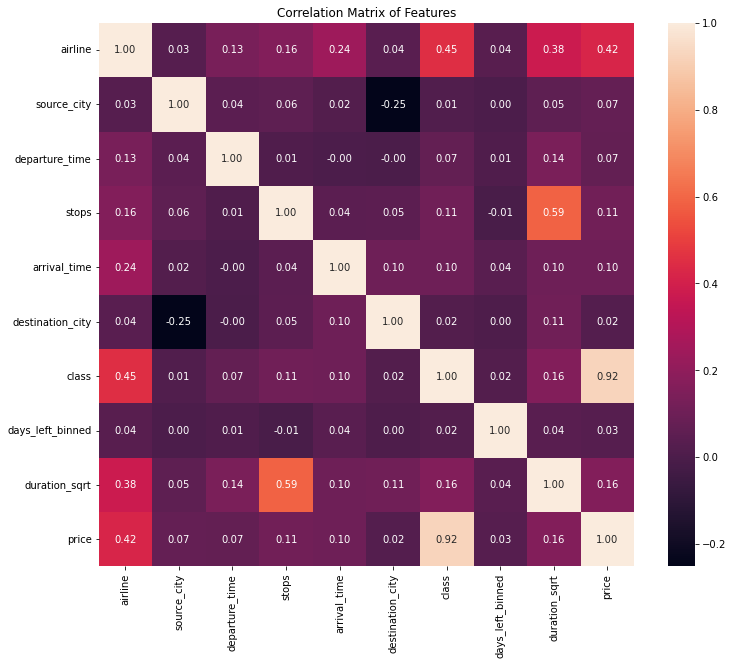

In [4]:
correlation_matrix = df1.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

One way to visualise the p-value associated with each correlation coefficients is to create a `mask` argument to be used with `heatmap()` function. Here, we first create a new function called `corr_sig()` which will calculate the p-values. Then, we filter out the correlation values whose p-value is greater than 0.05 (95% Significance Level) and use these values to create the mask argument. Finally, we create a new correlation matrix specifying the `mask` argument.

Reference: https://copyprogramming.com/howto/seaborn-correlation-matrix-with-p-values-with-python

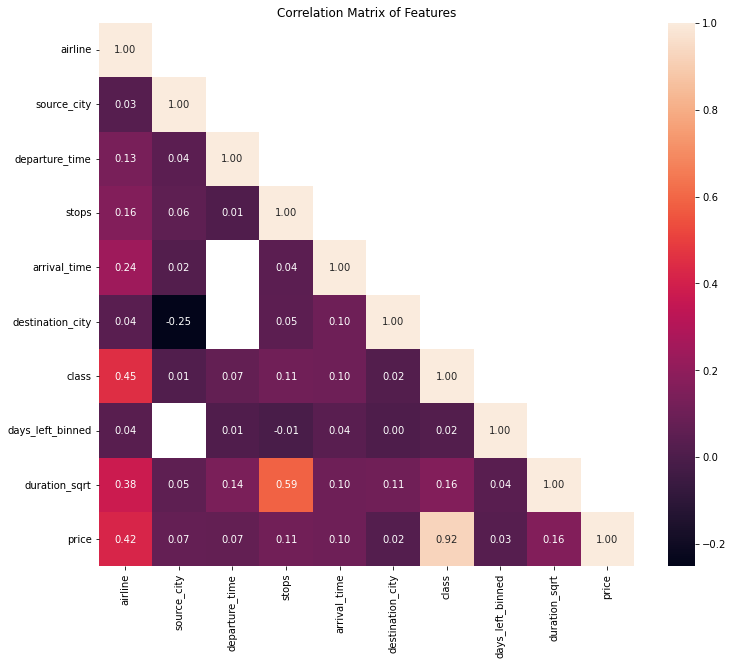

In [5]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(df1)
mask = np.invert(np.tril(p_values<0.05))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Features')
plt.show()

Another way to visualise this is to tabulate the p-values. Here we create a new function called `corr_full()` to implement such. 

Reference: https://pub.towardsai.net/building-correlation-matrix-with-p-values-in-python-76ffd3c2365e

In [6]:
 def corr_full(df, numeric_only=True, rows=['corr', 'p-value', 'obs']):
    
    # Calculate Pearson correlation coefficients
    corr_matrix = df.corr(method='pearson')
    
    # Calculate the p-values using scipy's pearsonr
    pvalue_matrix = df.corr( 
        method=lambda x, y: pearsonr(x, y)[1])
    
    # Calculate the non-null observation count for each column
    obs_count = df.apply(lambda x: x.notnull().sum())
    
    # Calculate observation count for each pair of columns
    obs_matrix = pd.DataFrame(
        index=corr_matrix.columns, columns=corr_matrix.columns)
    for col1 in obs_count.index:
        for col2 in obs_count.index:
            obs_matrix.loc[col1, col2] = min(obs_count[col1], obs_count[col2])
        
    # Create a multi-index dataframe to store the formatted correlations
    formatted_table = pd.DataFrame(
        index=pd.MultiIndex.from_product([corr_matrix.columns, rows]), 
        columns=corr_matrix.columns
    )
    
    # Assign values to the appropriate cells in the formatted table
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if 'corr' in rows:
                formatted_table.loc[
                    (col1, 'corr'), col2] = corr_matrix.loc[col1, col2]
            
            if 'p-value' in rows:
                # Avoid p-values for diagonal they correlate perfectly
                if col1 != col2:
                    formatted_table.loc[
                        (col1, 'p-value'), col2] = f"({pvalue_matrix.loc[col1, col2]:.4f})"
            if 'obs' in rows:
                formatted_table.loc[
                    (col1, 'obs'), col2] = obs_matrix.loc[col1, col2]
    
    return(formatted_table.fillna('')
           .style.set_properties(**{'text-align': 'center'}))

In [7]:
correlation_matrix_full = corr_full(df1, rows=['corr', 'p-value'])
correlation_matrix_full

### Multicollinearity

Regression models are sensitive to multicollinearity. Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques. one such technique is the Variance Inflation Factor(VIF)

Before we calculate the VIF values, we will need to drop the dependent variable. To do so, we will create a new df called X which will only include independent variables

In [8]:
X = df1. drop('price', axis=1)
X.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt
0,-1.368800,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522
1,-1.368800,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940
2,-1.562898,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522
3,0.885018,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006
4,0.885018,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940


Now that the data is ready, we will compute the VIF values for each feature in our dataset.

In [9]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

            feature       VIF
0           airline  1.499783
1       source_city  1.079051
2    departure_time  1.036798
3             stops  1.558686
4      arrival_time  1.074553
5  destination_city  1.096754
6             class  1.256327
7  days_left_binned  1.004452
8     duration_sqrt  1.799448


There are currently no established criteria for identifying the extent of variance inflation factors that result in poorly estimated coefficients. A frequently used benchmark for VIF in numerous regression studies is VIF ≥ 5. Based on the results above, it appears that none of our features have issue with multicollinearity. 

### 4.0 Multiple Linear Regression Model Fitting

### Test Train Split

In [10]:
X = df1. drop('price', axis=1)
y = df1['price']

We will use the rule-of-thumb 80:20 split for train and test datasets respectively. We will use `train_test_split()` function from sklearn to split the dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

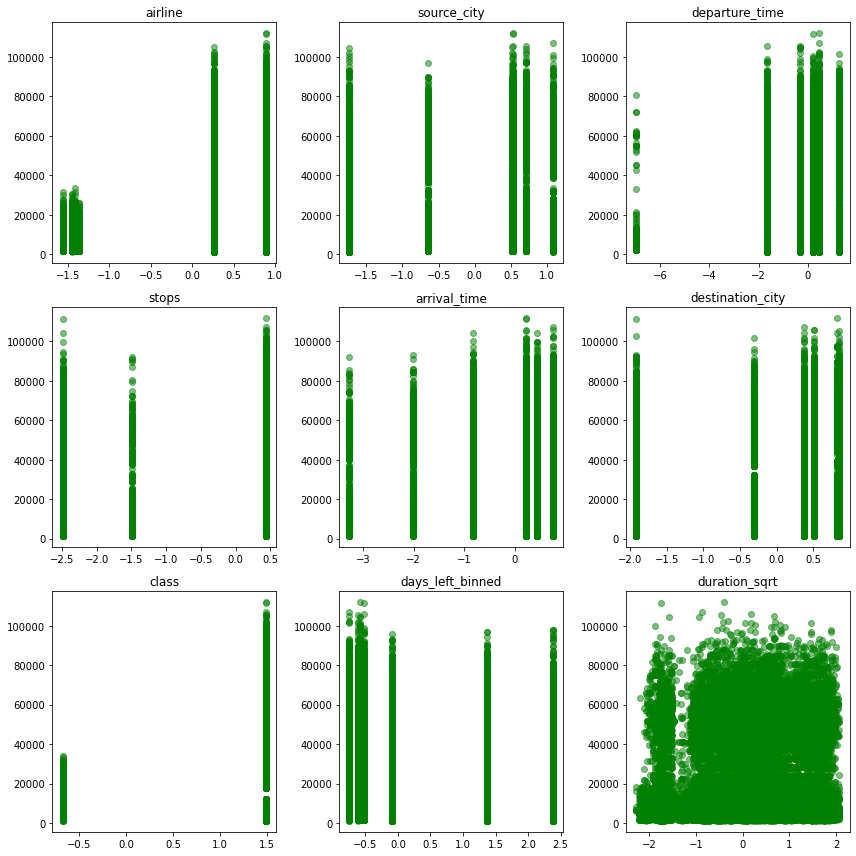

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, col in enumerate(X_train.columns):
    ax = axs[i // 3, i % 3]  # Calculate subplot position
    ax.scatter(X_test[col], y_test, color='g', alpha=0.5)
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Model Fitting

In [13]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

### Intercept and Coefficient Estimates

Let's try to display the **intercept** and **coefficient estimates** from the `mlr` model that we just fitted.

In [14]:
intercept = mlr.intercept_
coefficients = list(zip(X, mlr.coef_))

# Creating a DataFrame to display the results in a tabulated format
results = pd.DataFrame(coefficients, columns=['Variable', 'Coefficient'])
results.loc[len(results.index)] = ['Intercept', intercept] 

print(results)

           Variable   Coefficient
0           airline     33.215316
1       source_city   1440.403205
2    departure_time     52.530004
3             stops     64.026431
4      arrival_time     -0.383365
5  destination_city    491.980028
6             class  20776.403577
7  days_left_binned    261.530637
8     duration_sqrt    172.718494
9         Intercept  20631.914236


### 5.0 Prediction

In [15]:
y_pred = mlr.predict(X_test)

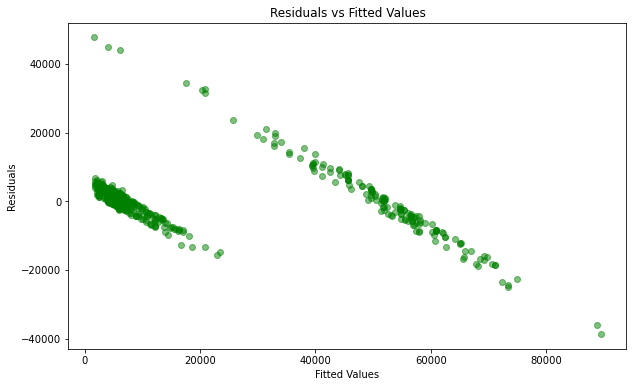

In [62]:
predicted_values = y_pred[1:500]
fitted_values = y_test[1:500]
residuals = predicted_values - fitted_values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, color ='g', alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

### 6.0 Evaluation

In [18]:
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mean_absolute_percent_error=metrics.mean_absolute_percentage_error(y_test, y_pred) 
mse=metrics.mean_squared_error(y_test, y_pred) 
r2=metrics.r2_score(y_test, y_pred)
adjustedr2 = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)


metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(r2, 4)),str(round(adjustedr2, 4)), str(round(mean_absolute_error, 4)), str(round(mean_absolute_percent_error, 4)), str(round(mse, 4)), str(round(np.sqrt(mse), 4))]}

df_metric = pd.DataFrame(metric_resuls)

print(df_metric)

                           Metric          Value
0                        R2 Score         0.8582
1               Adjusted R2 Score         0.8582
2             Mean Absolute Error      5161.3459
3    Mean Absolute % Error (MAPE)         0.5481
4        Mean Squared Error (MSE)  71990863.7884
5  Root Mean Squared Error (RMSE)       8484.743


Based on the results of the evaluation metrics, following insights may be inferred.
* The R2 score is 0.8256 and the adjusted R2 score is 0.8256, which means that approximately 82.56% of the variance in the target variable is explained by your model. A high R2 score indicates an adequate model fit.
* The Mean Squared Error (MSE) is 0.1743, which suggests that the overall prediction error is relatively low. 
* The Mean Absolute Error (MAE) is 0.3144 and Root Mean Squared Error (MSE) is 0.4175, indicating somewhat good accuracy in predictions. 

In [19]:
score = metrics.r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

The accuracy of our model is 86.0%


### 7.0 Ordinary Least Square Regression with Stepwise Removal

In [20]:
import statsmodels.api as sm

In [21]:
ols_m1 = sm.OLS(y_train, X_train).fit()
print(ols_m1.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          2.322e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                        13:48:48   Log-Likelihood:                     -2.7048e+06
No. Observations:              236551   AIC:                                  5.410e+06
Df Residuals:                  236542   BIC:                                  5.410e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [22]:
new_X = df1. drop(['price','airline'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m2 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.467
Method:                 Least Squares   F-statistic:                          2.595e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                        13:48:49   Log-Likelihood:                     -2.7045e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236543   BIC:                                  5.409e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [23]:
new_X = df1. drop(['price','airline', 'stops'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m3 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m3.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          2.982e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                        13:48:50   Log-Likelihood:                     -2.7047e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236544   BIC:                                  5.409e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [24]:
new_X = df1. drop(['price','airline','stops','arrival_time'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m4 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m4.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          3.483e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                        13:48:51   Log-Likelihood:                     -2.7047e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236545   BIC:                                  5.409e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [25]:
new_X = df1. drop(['price','airline','stops','arrival_time','departure_time'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m5 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m5.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.468
Method:                 Least Squares   F-statistic:                          4.169e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                        13:48:52   Log-Likelihood:                     -2.7046e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236546   BIC:                                  5.409e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

All parameters are statistically significant after 5th iteration of stepwise selection. However, adjusted R-squared value after stepwise regression **did not improve** significantly.

There is a possible **negative autocorrelation** in the error terms, provided by 0.295 value of Durbin-Watson statistic. The presence of correlation in error terms drastically reduces model’s accuracy. If the error terms are correlated, the estimated standard errors tend to underestimate the true standard error.

### 8.0 2nd Run of Multiple Linear Regression

In [30]:
mlr2 = LinearRegression()
mlr2.fit(new_X_train, new_y_train)

intercept = mlr2.intercept_
coefficients = list(zip(new_X, mlr2.coef_))

# Creating a DataFrame to display the results in a tabulated format
results = pd.DataFrame(coefficients, columns=['Variable', 'Coefficient'])
results.loc[len(results.index)] = ['Intercept', intercept] 

print(results)

           Variable   Coefficient
0       source_city   1423.199577
1  destination_city    497.712095
2             class  20780.025499
3  days_left_binned    261.033621
4     duration_sqrt    224.904569
5         Intercept  20623.556979


In [31]:
new_y_pred = mlr2.predict(new_X_test)

In [34]:
new_mean_absolute_error = metrics.mean_absolute_error(new_y_test, new_y_pred)
new_mean_absolute_percent_error=metrics.mean_absolute_percentage_error(new_y_test, new_y_pred) 
new_mse=metrics.mean_squared_error(new_y_test, new_y_pred) 
new_r2=metrics.r2_score(new_y_test, new_y_pred)
new_adjustedr2 = 1 - (1-new_r2) * (len(y)-1)/(len(y)-new_X.shape[1]-1)


new_metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(new_r2, 4)),str(round(new_adjustedr2, 4)), str(round(new_mean_absolute_error, 4)), str(round(new_mean_absolute_percent_error, 4)), str(round(new_mse, 4)), str(round(np.sqrt(new_mse), 4))]}

new_df_metric = pd.DataFrame(new_metric_resuls)

print(new_df_metric)

                           Metric          Value
0                        R2 Score         0.8555
1               Adjusted R2 Score         0.8555
2             Mean Absolute Error      5235.2527
3    Mean Absolute % Error (MAPE)          0.562
4        Mean Squared Error (MSE)  74261419.3579
5  Root Mean Squared Error (RMSE)      8617.5066


Compare these results to previous model,

In [33]:
print(df_metric)

                           Metric          Value
0                        R2 Score         0.8582
1               Adjusted R2 Score         0.8582
2             Mean Absolute Error      5161.3459
3    Mean Absolute % Error (MAPE)         0.5481
4        Mean Squared Error (MSE)  71990863.7884
5  Root Mean Squared Error (RMSE)       8484.743


### 9.0 Regularization: Ridge Regression

In this section, we will try to apply ridge regression and see if the performance improves.

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295689 entries, 0 to 297920
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           295689 non-null  float64
 1   source_city       295689 non-null  float64
 2   departure_time    295689 non-null  float64
 3   stops             295689 non-null  float64
 4   arrival_time      295689 non-null  float64
 5   destination_city  295689 non-null  float64
 6   class             295689 non-null  float64
 7   days_left_binned  295689 non-null  float64
 8   duration_sqrt     295689 non-null  float64
dtypes: float64(9)
memory usage: 22.6 MB


In [48]:
from sklearn.linear_model import Ridge

n_features = 9
n_alpha = 200

beta=np.zeros((n_features,n_alpha))
score=np.zeros((n_alpha, 1))

for alpha in range(n_alpha):
    ridge = Ridge(alpha=alpha) # trying out different values of alpha
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    #score[alpha] = mean_squared_error(y_test, y_pred)
    for i in range(9):
        beta[i][alpha] = ridge.coef_[i]

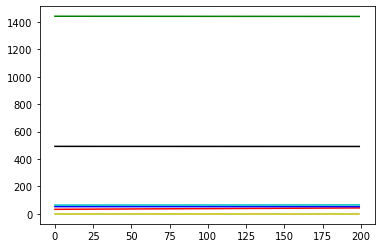

In [49]:
i = 0
plt.plot(beta[i+0], 'r', beta[i+1], 'g', beta[i+2], 'b', beta[i+3], 'c', beta[i+4], 'y', beta[i+5], 'k')
plt.show()

In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Create a Ridge regressor object
ridge = Ridge()

# Create the grid search object
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [41]:
# Get the best parameters
print("Best parameters: ", grid.best_params_)

Best parameters:  {'alpha': 0.001}


In the code chunk above, grid.best_params_ is a dictionary that contains the best hyperparameters found by GridSearchCV. We extract the best alpha value, which is the regularization strength for Ridge Regression, and use it to create a new Ridge object. Then, we fit this new model to the data.

Now, we will create a new Ridge regressor with the best parameters

In [42]:
ridge_best = Ridge(alpha=0.001)

# Fit the model to the data
ridge_best.fit(X_train, y_train)

Ridge(alpha=0.001)

In [51]:
 ridge_y_pred = ridge_best.predict(X_test)

In [55]:
ridge_mean_absolute_error = metrics.mean_absolute_error(y_test, ridge_y_pred)
ridge_mean_absolute_percent_error=metrics.mean_absolute_percentage_error(y_test, ridge_y_pred) 
ridge_mse=metrics.mean_squared_error(y_test, ridge_y_pred) 
ridge_r2=metrics.r2_score(y_test, ridge_y_pred)
ridge_adjustedr2 = 1 - (1-ridge_r2) * (len(y)-1)/(len(y)-new_X.shape[1]-1)


ridge_metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(ridge_r2, 4)),str(round(ridge_adjustedr2, 4)), str(round(ridge_mean_absolute_error, 4)), str(round(ridge_mean_absolute_percent_error, 4)), str(round(ridge_mse, 4)), str(round(np.sqrt(ridge_mse), 4))]}

ridge_df_metric = pd.DataFrame(ridge_metric_resuls)

print(ridge_df_metric)

                           Metric          Value
0                        R2 Score         0.8582
1               Adjusted R2 Score         0.8582
2             Mean Absolute Error      5161.3459
3    Mean Absolute % Error (MAPE)         0.5481
4        Mean Squared Error (MSE)  71990863.7892
5  Root Mean Squared Error (RMSE)       8484.743


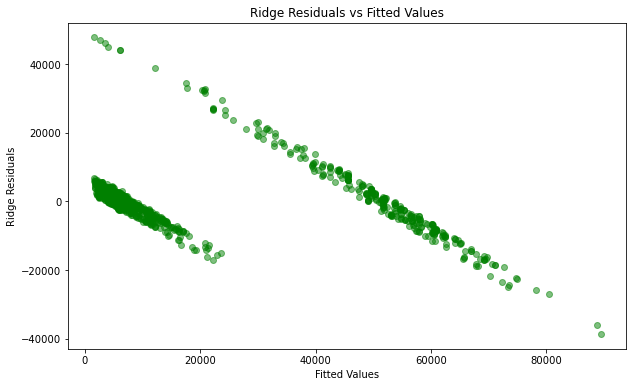

In [65]:
ridge_predicted_values = ridge_y_pred[1:1000]
fitted_values = y_test[1:1000]
ridge_residuals = ridge_predicted_values - fitted_values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, ridge_residuals, color ='g', alpha=0.5)
plt.title('Ridge Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Ridge Residuals')
plt.show()

## Overall Remarks

From the plot, it’s clear that there’s a noticeable pattern where residuals are mostly positive at lower actual values and become increasingly negative as actual values rise. This indicates potential issues with the model fit or heteroscedasticity.

In a well-specified model, the residuals should be randomly scattered around zero across all levels of the explanatory variable. However, in this case, as the actual values increase, the residuals become more negative. This indicates that the model is not capturing some underlying pattern in the data.

**Possible issues of why Linear Regression is not appropriate to use:**

* The relationship between predictors and outcome variable is not linear, violating normality assumption.
* There is clear autocorrelation between the residual (error) terms, violating random assumption.